3 Cross Validation And L2 Regularization

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(datadir, validation=False, split=0.9, rand_seed=100):
    df_train = pd.read_table("crime-train.txt")
    df_test = pd.read_table("crime-test.txt")

    X_test = df_test.iloc[:, 1:].values
    y_test = df_test.iloc[:, :1].values.reshape(-1)

    if validation:
        df_train_split = df_train.sample(frac=split, random_state=rand_seed)
        df_val_split = df_train.drop(df_train_split.index)
        
        X_train = df_train_split.iloc[:, 1:].values
        y_train = df_train_split.iloc[:, :1].values.reshape(-1)
        X_val = df_val_split.iloc[:, 1:].values
        y_val = df_val_split.iloc[:, :1].values.reshape(-1)
        
        return (X_train, y_train, X_val, y_val, X_test, y_test, df_train, df_test)
    else:
        X_train = df_train.iloc[:, 1:].values
        y_train = df_train.iloc[:, :1].values.reshape(-1)
        return (X_train, y_train, X_test, y_test, df_train, df_test)

def ridge_solver(X, y, w, reg):
    z = (X ** 2).sum(axis=0)
    while True:
        w_old = np.copy(w)
        for j in range(w.shape[0]):
            w[j] = 0
            y_ = np.matmul(X, w)
            rho_j = np.dot(X[:, j], y - y_)
            w[j] = rho_j / (z[j] +reg)
            
        # check for convergence
        if np.max(w_old - w) < 1e-6:
            return w

def ridge_models(X, y, regs):
    W = np.empty([0, X.shape[1]], dtype=np.float64)
    w = np.random.normal(0, 1, W.shape[1])
    for i in range(regs.shape[0]):
        w = np.copy(W[-1]) if i != 0 else np.random.normal(0, 1, W.shape[1])
        W = np.vstack((W, ridge_solver(X, y, w, regs[i])))
    return W

def plot_sqerr(X, y, W, regs):
    err = ((np.matmul(X, W.T).T - y) ** 2).sum(axis=1)
    #plt.title('squared erros:')
    plt.xlabel('log($\lambda$)')
    plt.ylabel('squared errors')
    plt.plot(np.log(regs), err, marker='o')
    plt.show()

def plot_small_coeffcients(W, regs):
    lam=1e-4
    W_count = ((W < lam) * 1).sum(axis=1)
    plt.xlabel('regs')
    plt.ylabel('number of small coeffcients')
    plt.plot(regs, W_count, marker='o')
    plt.show()

def tune_reg(X, y, W, regs):
    err = ((np.matmul(X, W.T).T - y) ** 2).sum(axis=1)
    best_reg = regs[np.argmin(err)]
    return best_reg

def max_min_w(df, W, regs, best_reg):
    best_w = W[np.where(regs==best_reg), :]
    max_w_i = np.argmax(best_w)
    min_w_i = np.argmin(best_w)
    return df.columns[[max_w_i + 1, min_w_i + 1]].tolist()

X_train, y_train, X_val, y_val, X_test, y_test, df_train, df_test = load_data('data', validation=True, split=0.9)
regs = np.array([10000.0 / (2 ** i) for i in range(10)])
W = ridge_models(X_train, y_train, regs)

3.(1) A plot of $log(\lambda)$ against the squared error in the 10-folder splited training data. (15 points)

Solution:

A plot of log($\lambda$) against the squared error in the training data shows as follow.

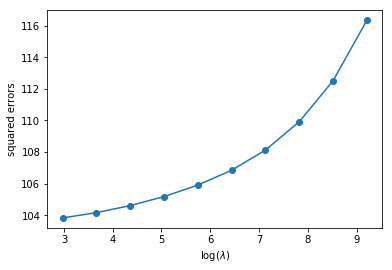

In [180]:
plot_sqerr(X_train, y_train, W, regs)

3.(2) A plot of $log(\lambda)$ against the squared error in the test data. (10 points)

Solution:

A plot of log($\lambda$) against the squared error in the test data shows as follow.

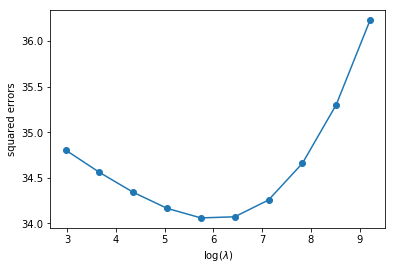

In [181]:
plot_sqerr(X_test, y_test, W, regs)

3.(3) A plot of $\lambda$ against the number of small coefficients and a brief commentary on the task of selecting $\lambda$. (15 points)

Solution:

Suppose small coefficients threshold 1e-3.

A plot of $\lambda$ against the number of small coefficients shows as follow.

And here we use the validation dataset to tune the hyper parameter $\lambda$.

We find the $\lambda$(reg) for which the validation error is the least. Since the model wasn’t trained on the validation set and we have enough data we just use a 10% split on the original training set
for the validation set. This gives us a good approximation for the error.

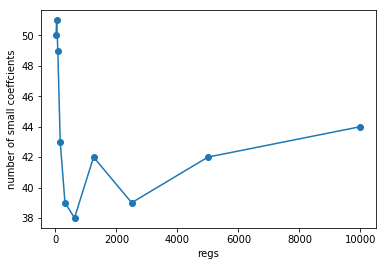

In [182]:
plot_small_coeffcients(W, regs)

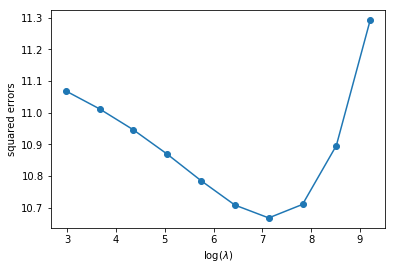

Best validation error at log(lambda)=7.1308988302963465


In [183]:
plot_sqerr(X_val, y_val, W, regs)
best_reg = tune_reg(X_val, y_val, W, regs)
print ('Best validation error at log(lambda)=' + str(np.log(best_reg)))

3.(4) For the $\lambda$ that gave the best test set performance, which variable had the largest (most positive) coefficient? What about the most negative? Discuss briefly. (10 points)

Solution: 

Most positive coefficient: PctIlleg: percentage of kids born to never married (numeric - decimal) 

Most negative coefficient: PctKids2Par: percentage of kids in family housing with two parents (numeric - decimal)

Which shows that houses with higher "percentage of kids born to never married" leads to a higher crime rate and houses with higher "percentage of kids in family housing with two parents" leads to lower crime rate.

In [178]:
max_w_i, min_w_i = max_min_w(df_train, W, regs, best_reg)
print ('Most positive coefficient: ' + max_w_i +'\n' 'Most negative coefficient: ' + min_w_i)

Most positive coefficient: PctIlleg
Most negative coefficient: PctKids2Par
